## Imports

In [1]:
# Imports
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
import torch
from monai.transforms import (
    Resize,
    ScaleIntensityRange,
    Compose,
    Transpose
)


c:\Users\P095550\Documents\CRLM-morph-features\CRLM-morph-features\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# DATA UNDERSTANDING #

### Showing individual scan

Data type: float64


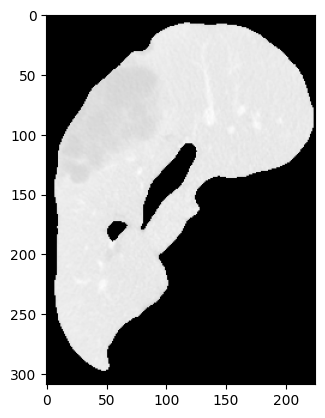

In [4]:
#data imports
dataset_path = 'L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/Training/paired_scans'
dataset_segmentation_path = 'L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/labels made by AI model cropped'

#first image as an example
image = nib.load(os.path.join(dataset_path, 'CAESAR082_0.nii.gz'))
image_data = image.get_fdata()

# Check the data type of the image data
print("Data type:", image_data.dtype)

#show an example image
plt.imshow(image_data[:,:,50], cmap='gray')

In [3]:
#show segmentation
segm_img = nib.load(os.path.join(dataset_segmentation_path, 'CAESAR001_0.nii.gz'))
segm_img_data = segm_img.get_fdata()
segm_img_header = segm_img.header

#show an example image
plt.imshow(segm_img_data[:,:,40])


NameError: name 'dataset_segmentation_path' is not defined

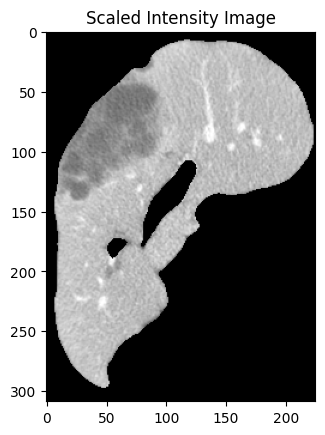

[-1000.         -1000.         -1000.         -1000.
 -1000.         -1000.         -1000.         -1000.
 -1000.         -1000.         -1000.         -1000.
 -1000.         -1000.         -1000.         -1000.
 -1000.         -1000.         -1000.         -1000.
 -1000.         -1000.         -1000.         -1000.
 -1000.         -1000.         -1000.         -1000.
 -1000.         -1000.         -1000.         -1000.
 -1000.         -1000.         -1000.         -1000.
 -1000.         -1000.         -1000.         -1000.
 -1000.         -1000.         -1000.         -1000.
 -1000.         -1000.         -1000.         -1000.
 -1000.         -1000.         -1000.         -1000.
 -1000.         -1000.         -1000.         -1000.
 -1000.         -1000.         -1000.         -1000.
    42.00933345    47.9976757     54.00490862    59.99325088
    69.00410026    74.99244251    83.00208641    77.99605898
    66.0004838     73.00892221    76.99485349    70.00530575
    75.993648      75.

In [ ]:
# Load the paired scan
paired_scans_path = 'L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/Training/paired_scans'
scan_path = os.path.join(paired_scans_path, 'CAESAR082_0.nii.gz')
paired_scan = nib.load(scan_path)
paired_scan_data = paired_scan.get_fdata()

# Apply ScaleIntensity transform
transform=[ScaleIntensityRange(a_min=-100, a_max=200, b_min=0.0, b_max=1.0, clip=True), Resize((256, 256, 64), mode="trilinear"),
                                                Transpose((2, 1, 0))]
scaled_paired_scan_data = transform(paired_scan_data)

# Show the scaled image
plt.imshow(scaled_paired_scan_data[50, :, :], cmap='gray')
plt.title("Scaled Intensity Image")
plt.show()
print(paired_scan_data[50, 40, :])  # Original image
print(scaled_paired_scan_data[50, 40, :])

### Find max HU-value

In [ ]:
# Initialize a variable to store the maximum HU value
max_hu_value = float('-inf')

# Iterate through all files in the paired_scans directory
for file_name in os.listdir(paired_scans_path):
    if file_name.endswith('.nii.gz'):  # Ensure we only process NIfTI files
        scan = nib.load(os.path.join(paired_scans_path, file_name))
        scan_data = scan.get_fdata()
        max_hu_value = max(max_hu_value, scan_data.max())  # Update the maximum HU value if a higher value is found

print("Maximum HU value in paired_scans:", max_hu_value)


In [ ]:
# Collect all HU values from all scans in the paired_scans directory
hu_values = []

for file_name in os.listdir(paired_scans_path):
    if file_name.endswith('.nii.gz'):  # Ensure we only process NIfTI files
        scan = nib.load(os.path.join(paired_scans_path, file_name))
        scan_data = scan.get_fdata()
        hu_values.extend(scan_data.flatten())  # Flatten the 3D array and add to the list

# Convert the list to a numpy array for plotting
hu_values = np.array(hu_values)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(hu_values, bins=100, color='blue', alpha=0.7)
plt.title("Histogram of HU Values for All Scans")
plt.xlabel("HU Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## testing correct resize

In [ ]:
all_scans_path = 'L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/Training/all_scans'
output_folder = 'L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/Training'

# Load the scan
scan_path = os.path.join(all_scans_path, 'CAESAR001_0_0000.nii.gz')
scan = nib.load(scan_path)
scan_data = scan.get_fdata()

print("Original scan shape:", scan_data.shape)
# Define the desired output size
output_size = (256, 256, 64)  # Example size

# Resize the scan using MONAI
resize_transform = Compose([Resize(spatial_size=output_size, mode='trilinear')])
resized_scan_data = resize_transform(scan_data)
print("Resized scan shape:", resized_scan_data.shape)


Original scan shape: (512, 512, 208)


RuntimeError: applying transform <monai.transforms.spatial.array.Resize object at 0x0000014C49448B20>

## Calculate class weights

In [ ]:
print("Current working directory:", os.getcwd())


# Read the CSV file
training_labels = pd.read_csv(os.path.join(os.getcwd(), "training_labels.csv"))

# Count occurrences of 1 in all columns separately
occurrences = training_labels.eq(1).sum()

class_counts = occurrences.tolist()
print(class_counts)

total_size = training_labels.shape[0]

class_weights = total_size / (torch.tensor(class_counts, dtype=torch.float32) + 1e-6)   #avoid division by zero
class_weights = torch.tensor(class_weights, dtype=torch.float32)
print(class_weights)

Current working directory: c:\Users\P095550\OneDrive - Amsterdam UMC\Documenten\GitHub\CRLM-morph-features
[50, 36, 28, 237, 119, 32, 244, 99, 24]


C:\Users\P095550\AppData\Local\Temp\ipykernel_14840\1598768005.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(class_weights, dtype=torch.float32)


tensor([ 5.7600,  8.0000, 10.2857,  1.2152,  2.4202,  9.0000,  1.1803,  2.9091,
        12.0000])
